In [8]:
#Nate's Gradient Methods

import numpy as np
from matplotlib import pyplot as plt
from autograd import numpy as anp
from autograd import grad
from autograd import elementwise_grad, jacobian
import sympy as sy
from scipy import linalg as la
from scipy import optimize as opt
import pdb

This function implements the exact method of steepest descent, using a one-dimensional optimization method to choose the step size to compute the minimum of function f. We use 
$x_{k+1} = x_k - \alpha_{k}Df(x_k)$ with $\alpha_k = argmin_{\alpha} f(x_k - \alpha_{}Df(x_k))$.

In [2]:
def steepest_descent(f, Df, x0, tol=1e-5, maxiter=100):
    """Compute the minimizer of f using the exact method of steepest descent.

    Parameters:
        f (function): The objective function. Accepts a NumPy array of shape
            (n,) and returns a float.
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        tol (float): The stopping tolerance.
        maxiter (int): The maximum number of iterations to compute.

    Returns:
        ((n,) ndarray): The approximate minimum of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    
    #We want floats for the grad module to work
    x0 = np.float64(x0)
    #We want to count the iterations and get the bool conv
    iterations = 0
    conv = False
    #Now we iterate
    for i in range(maxiter):
        #Define y0 to make things easier
        y0 = Df(x0).T
        #Find alpha
        fcn_alpha = lambda alpha: f(x0 - alpha*y0)
        alpha0 = opt.minimize_scalar(fcn_alpha).x
        #Compute x1
        x1 = x0 - alpha0*y0
        #Count!
        iterations += 1
        #Check if we have convergence already
        if la.norm(Df(x1),np.inf) < tol:
            conv = True
            break
        #Start again
        x0 = x1

    #Get the value
    return x1, conv, iterations

Here we use conjugate gradient rather than steepest descent. (The direction of descent is the conjugate direction, which is guaranteed to descend but may not be the direction of steepest descent.) Note that solving $Q\textbf{x} = \textbf{b}$ as we do here is equivalent to minimizing the quadratic function $f(\textbf{x}) = \frac{1}{2}\textbf{x}^{T}Q\textbf{x} + \textbf{b}^{T}\textbf{x} + c$.

In [9]:
def conjugate_gradient(Q, b, x0, tol=1e-4):
    """Solve the linear system Qx = b with the conjugate gradient algorithm.

    Parameters:
        Q ((n,n) ndarray): A positive-definite square matrix.
        b ((n, ) ndarray): The right-hand side of the linear system.
        x0 ((n,) ndarray): An initial guess for the solution to Qx = b.
        tol (float): The convergence tolerance.

    Returns:
        ((n,) ndarray): The solution to the linear system Qx = b.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    
    #We first initialize r0 and step direction d0
    n = len(b)
    r0 = Q@x0-b
    d0 = -r0
    #We want to count the iterations and get the bool conv
    iterations = 0
    conv = False
    #Now we iterate
    for k in range(n+1):
        #Get the step size
        alpha0 = np.inner(r0,r0)/np.inner(d0,Q@d0)
        #Get x1 (as well as r1 and beta1 and step direction d1, involved in calculation).
        x1 = x0 + alpha0*d0
        r1 = r0 + alpha0*Q@d0
        beta1 = np.inner(r1,r1)/np.inner(r0,r0)
        d1 = -r1 + beta1*d0
        #Count!
        iterations += 1
        #Check if we have convergence already
        if la.norm(r0) < tol:
            conv = True
            break
        #Start again
        x0 = x1
        r0 = r1
        d0 = d1

    #Get the value
    return x1, conv, iterations

Here we do non-linear conjugate gradient. This works for more general functions, though convergence is not guaranteed as it is with the previous function. Here we have the step size $\alpha_{k} = argmin_{\alpha}f(\textbf{x}_k + \alpha_{}\textbf{d}_k)$.

In [4]:
def nonlinear_conjugate_gradient(f, Df, x0, tol=1e-5, maxiter=100):
    """Compute the minimizer of f using the nonlinear conjugate gradient
    algorithm.

    Parameters:
        f (function): The objective function. Accepts a NumPy array of shape
            (n,) and returns a float.
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        tol (float): The stopping tolerance.
        maxiter (int): The maximum number of iterations to compute.

    Returns:
        ((n,) ndarray): The approximate minimum of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    
    #We want floats as before
    x0 = np.float64(x0)
    #New way to get r_k. (It's pretty much just Df(xk).)
    r0 = -Df(x0).T
    d0 = r0
    #Get alpha
    fcn_alpha = lambda alpha: f(x0 + alpha*d0)
    alpha0 = opt.minimize_scalar(fcn_alpha).x
    #Get x1
    x1 = x0 + alpha0 * d0
    #We want to count the iterations and get the bool
    iterations = 1
    conv = False
    #Now we iterate
    for k in range(1,maxiter):
        r1 = -Df(x1).T
        beta1 = np.inner(r1,r1)/np.inner(r0,r0)
        d1 = r1 + beta1*d0
        #Get alpha1
        fcn_alpha = lambda alpha: f(x1 + alpha*d1)
        alpha1 = opt.minimize_scalar(fcn_alpha).x
        #Now x2
        x2 = x1 + alpha1 * d1
        #Count!
        iterations += 1
        #Check if we have convergence already
        if la.norm(r1) < tol:
            conv = True
            break
        #Start again
        x1 = x2
        r0 = r1
        alpha0 = alpha1
        d0 = d1

    #Get the value
    return x2, conv, iterations

Here we apply the conjugate_gradient() function to find the linear regression of data in a file. We do this by solving the linear system $A^{T}A\textbf{x} = A^{T}\textbf{b}$.

In [11]:
def linear_regress(filename="linregression.txt",
          x0=np.array([-3482258, 15, 0, -2, -1, 0, 1829])):
    """Use conjugate_gradient() to solve the linear regression problem with
    the data from the given file, the given initial guess, and the default
    tolerance. Return the solution to the corresponding Normal Equations.
    """
    #Load data: i'th row is y_i, x_i1, x_i2, ..., x_in
    data = np.loadtxt(filename)
    #prob2 solves Qx = b
    b = data[:,0]
    m = len(b)
    A = np.hstack((np.ones(m).reshape((-1,1)), data[:,1:]))

    return conjugate_gradient(A.T@A, A.T@b, x0, tol=1e-4)[0]

In [15]:
linear_regress()

array([-3.48225800e+06,  1.50167080e+01, -3.58101458e-02, -2.02012486e+00,
       -1.03319899e+00, -5.11771269e-02,  1.82915588e+03])

Here is a class that performs logistic regression

In [12]:
class LogisticRegression1D:
    """Binary logistic regression classifier for one-dimensional data."""

    def fit(self, x, y, guess):
        """Choose the optimal beta values by minimizing the negative log
        likelihood function, given data and outcome labels.

        Parameters:
            x ((n,) ndarray): An array of n predictor variables.
            y ((n,) ndarray): An array of n outcome variables.
            guess (array): Initial guess for beta.

        """
        #Create the function
        f = lambda b: np.sum(np.log(1+np.exp(-(b[0]+b[1]*x))) + (1-y)*(b[0]+b[1]*x))
        beta = opt.fmin_cg(f, guess)
        #Store attributes
        self.beta0 = beta[0]
        self.beta1 = beta[1]

    def predict(self, x):
        """Calculate the probability of an unlabeled predictor variable
        having an outcome of 1.

        Parameters:
            x (float): a predictor variable with an unknown label.
        """
        return 1/( 1+np.exp(-(self.beta0 + self.beta1*x)) )

We use the above class to create a logistic regression for the data regardin O-ring failure leading up to Challenger space shuttle's explosion to calculate the likelihood that the O-rings would fail the day that they did (on January 28, 1986, killing all seven crew members). The function shows that with good gradient methods, this disaster could easily have been avoided. 

In [23]:
def logistic_regress(filename="challenger.npy", guess=np.array([20., -1.])):
    """Return the probability of O-ring damage at 31 degrees Farenheit.
    Additionally, plot the logistic curve through the challenger data
    on the interval [30, 100].

    Parameters:
        filename (str): The file to perform logistic regression on.
                        Defaults to "challenger.npy"
        guess (array): The initial guess for beta.
                        Defaults to [20., -1.]
    """
    #load in data
    data = np.load(filename)
    #Get columns
    x,y = data[:,0],data[:,1]
    #Use the class
    LR = LogisticRegression1D()
    #Fit to the data
    LR.fit(x,y,guess)
    #Now plot everything
    domain = np.linspace(30,100,200)
    plt.plot(domain,LR.predict(domain))
    #plot raw data
    plt.plot(x,y,'bo',label="Previous Damage")
    #What to return
    val_to_return = LR.predict(31)
    plt.plot(31,val_to_return,'go',label="P(Damage) at Launch")
    plt.title("Probability of O-Ring Damage")
    plt.legend()
    plt.show()

    print("Probabilty of O-ring failure: "+str(np.around(val_to_return*100,2))+"%")
    return val_to_return

         Current function value: 10.157597
         Iterations: 6
         Function evaluations: 112
         Gradient evaluations: 25


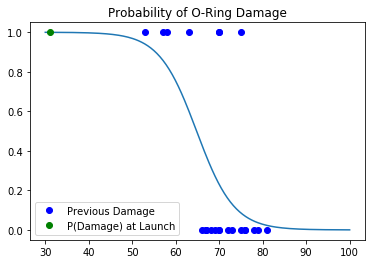

Probabilty of O-ring failure: 99.96%


0.999609671069125

In [24]:
logistic_regress()